# Introducción a Pytorch

Pytorch es un framework libre y de open source para la implementación de modelos de Deep Learning. Fue desarrollado principalmenete por el laboratorio de investigación de inteligencia artificial de Facebook (FAIR) y fue liberado en octubre del 2016. Ha sido ampliamente usado en Visión por Computadora, Procesamiento de Lenguaje Natural, Reinforcement Learning, entre otros temas.
Entre las características que tiene Pytorch, destacan las siguientes:

* El uso de ``torch``, que es una biblioteca optimizada para el computo tensorial, similar a Numpy, basado en el lenguaje de programación Lua. La gran ventaja de esta biblioteca es que puede ser operada desde CUDA para hacer uso de un GPU Nvidia`

* El uso explícito de la diferenciación automática. Es posible dar seguimiento a las operaciones numéricas realizadas y después calcular los gradientes en cada paso, esta es una herraminta muy útil en el proceso de Backward propagation en el entrenaminto de redes neuronales.

Ahora usaremos pytorch para hacer un clasificador binario basado en perceptrón de Rosenblatt.

Antes de empezar, será necesario introducir los siguientes módulos:
* torch
* torch.nn: consite de los modelos y funciones usados en la red neuronal.

In [1]:
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
plt.style.use('ggplot')

seed = 1321

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## Perceptrón de Rosenblatt 

![title](img/perceptron.png)
### Función de activación 

La función de activación esta dada por $f:\mathbb{R}\times [0, 1]: \rightarrow [0, 1]$, definida de la siguiente manera:
$$f(x, v) = \begin{cases}0 & \text{ si} x < 0, \\
v & \text{ si }x=0, \\
1 & \text{ si } x>0\end{cases}$$
En este caso suponemos que $y \in \{0, 1\}$.

/var/folders/_g/l2cwkcxj4516lhw6plp3849h0000gn/T/ipykernel_1203/2377047339.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5., 5., 0.1, dtype=torch.float32)


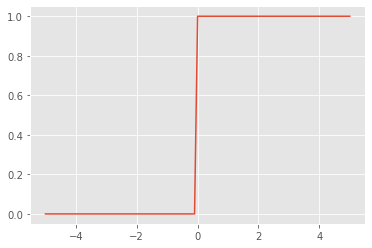

In [2]:

x = torch.range(-5., 5., 0.1, dtype=torch.float32)
y = torch.heaviside(x, torch.tensor(1, dtype=torch.float32))
plt.plot(x.numpy(), y.numpy())
plt.show()

$L = \mathbf{w}^t \cdot \mathbf{x} + \mathbf{b}$ (nn.Linear(n, 1))

$\mathbf{x} \in \mathbb{R}^{n}, \quad  \mathbf{b} \in \mathbb{R}^{1}$

In [3]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.layer = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the Perceptron

        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.heaviside(self.layer(x_in), torch.tensor(1, dtype=torch.float32))

### Generación de datos

In [4]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)
batch_size = 2000

In [5]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = list()
    y_array = np.zeros(batch_size)
    for i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=LEFT_CENTER))
            y_array[i] = 0
        else:
            x_data.append(np.random.normal(loc=RIGHT_CENTER))
            y_array[i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_array, dtype=torch.float32)

### Graficación de datos

In [6]:
X, Y = get_toy_data(batch_size)
X_numpy = X.numpy()
Y_numpy = Y.numpy()

left_x = list()
right_x = list()
left_colors = list()
right_colors =  list()

for x, y in zip(X_numpy, Y_numpy):

    if y == 1:
        color = 'blue'
        left_x.append(x)
        left_colors.append(color)

    else:
        color = 'red'
        right_x.append(x)
        right_colors.append(color)
        
left_x = np.stack(left_x)
right_x = np.stack(right_x)

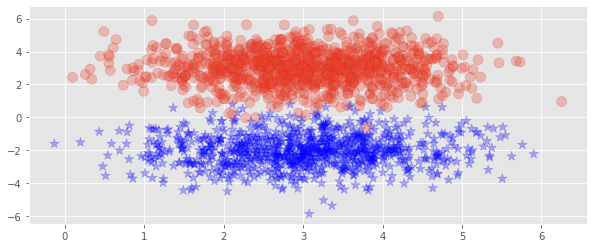

In [7]:
_, ax = plt.subplots(1, 1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100, alpha=0.3)
ax.scatter(right_x[:, 0], right_x[:, 1], edgecolor=right_colors, marker='o', s=100, alpha=0.3)

In [8]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

### Modelo

In [9]:
model = Perceptron(2)

In [10]:
for name, param in model.named_parameters():
    print(name, param)

layer.weight Parameter containing:
tensor([[ 0.6535, -0.4842]], requires_grad=True)
layer.bias Parameter containing:
tensor([0.3390], requires_grad=True)


In [11]:
with torch.no_grad(): 
    model.layer.weight[0, :] = torch.zeros(2) 
    model.layer.bias +=1

In [12]:
for name, param in model.named_parameters():
    print(name, param)

layer.weight Parameter containing:
tensor([[0., 0.]], requires_grad=True)
layer.bias Parameter containing:
tensor([1.3390], requires_grad=True)


## Perceptrón + Sigmoid

Sea $f: \mathbb{R} \rightarrow [0, 1]$ dada por:
$$f(x) = \frac{1}{1 + e^{-x}}$$
Aproximaremos la función Heviside usando $f$.

/var/folders/_g/l2cwkcxj4516lhw6plp3849h0000gn/T/ipykernel_1203/2436867774.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-5., 5., 0.1)


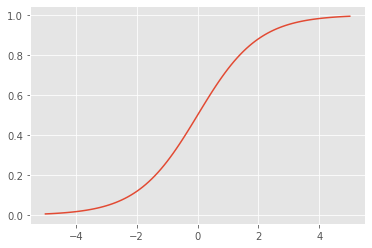

In [13]:
x = torch.range(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

In [14]:
class PerceptronS(Perceptron):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(PerceptronS, self).__init__(input_dim)

    def forward(self, x_in):
        """The forward pass of the Perceptron

        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.layer(x_in))

### Función objetivo

La función objetivo para este caso es *Binary Cross-Entropy Loss*, para el conjunto de etiquetas y predicciones $Y= \{y_1, y_2, \cdots, y_n \}$ y $\hat Y = \{\hat y_1, \hat y_2, \cdots,\hat y_n \}$, respectivamente, la función se expresa de la siguiente manera:
$$L(Y, \hat Y)= -\frac{1}{n}\sum_{i=n}y_i \log(\hat y_i) + (1- \hat y_i)\log(1 -y_i)$$

In [15]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
ps = sigmoid(torch.rand(4, 1, requires_grad=True)) # probabilidades
y = torch.tensor([1, 0, 1, 0],  dtype=torch.float32).view(4, 1)
loss = bce_loss(ps, y)
print(ps)
print(loss)

tensor([[0.6045],
        [0.6525],
        [0.5112],
        [0.5890]], grad_fn=<SigmoidBackward>)
tensor(0.7801, grad_fn=<BinaryCrossEntropyBackward>)


### Optimizador
El módulo ``torch.optim`` conforma la recopilación de los algoritmos de optimización más comunes dentro del entrenamiento de las redes neuronales. 

In [16]:
from torch import optim
perceptron = PerceptronS(input_dim=2)
lr = 0.01
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()

### Configuración inicial

### Separación de datos 

In [17]:
batch_size = 2000
X_data, y_truth = get_toy_data(batch_size)

# Shuffling & train/test split
shuffle_idx = np.arange(y_truth.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)

X_train, X_test = X_data[shuffle_idx[:1800]], X_data[shuffle_idx[1800:]]
y_train, y_test = y_truth[shuffle_idx[:1800]], y_truth[shuffle_idx[1800:]]

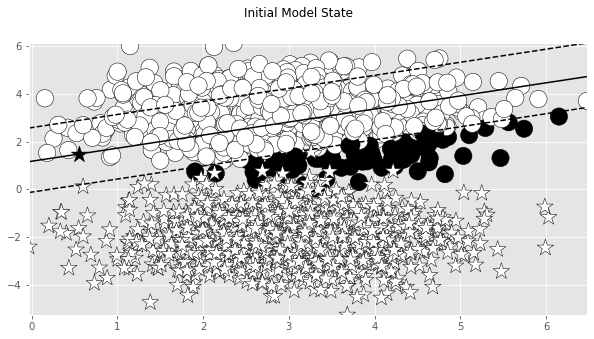

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, X_data, y_truth, ax=ax, title='Initial Model State')

### Entrenamiento

In [19]:
batch_size = 1000
n_epochs = 12
n_batches = 5

In [20]:
def fit(model, optimizer, criterion, X_train, y_train, X, y):
    losses = []
    change = 1.0
    last = 10.0
    epsilon = 1e-3
    epoch = 0
    while change > epsilon or epoch < n_epochs or last > 0.3:
    #for epoch in range(n_epochs):
        for _ in range(n_batches):
            optimizer.zero_grad()
            y_pred = perceptron(X_train).squeeze()
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
        
        
            loss_value = loss.item()
            losses.append(loss_value)

            change = abs(last - loss_value)
            last = loss_value
               
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        visualize_results(model, X, y, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
        #plt.axis('off')
        epoch += 1
        
    return losses

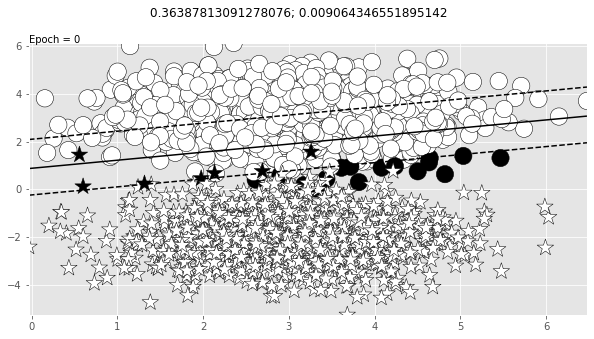

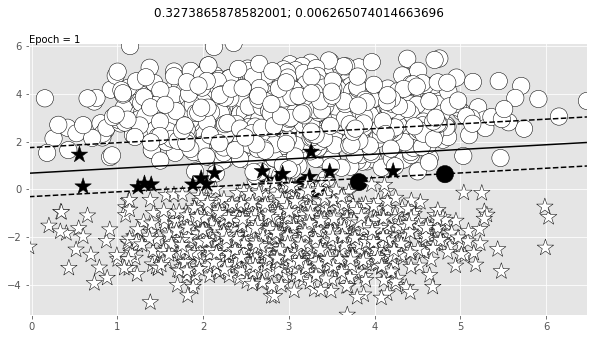

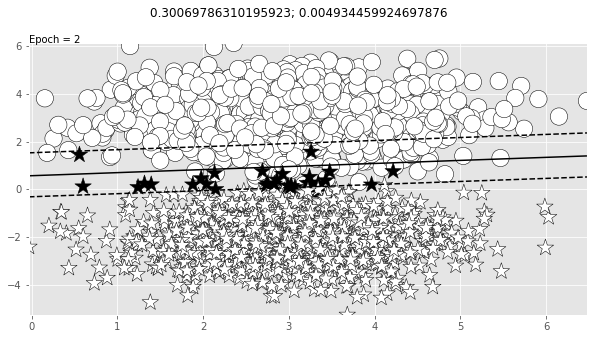

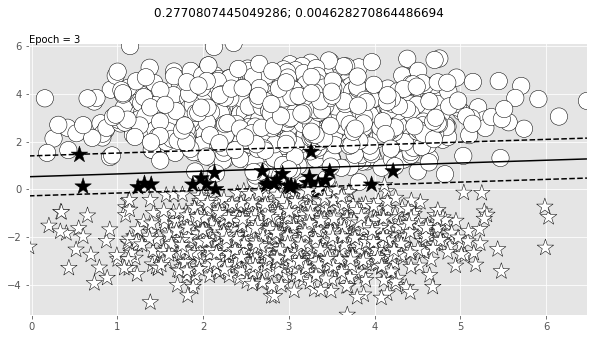

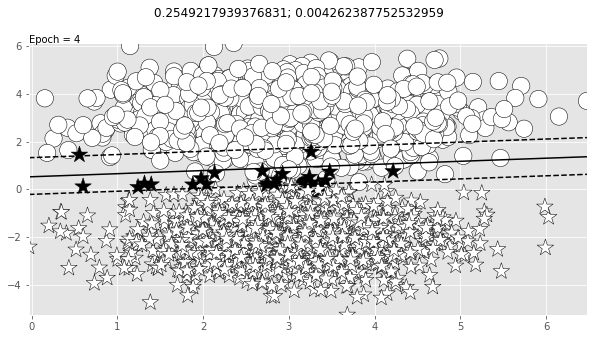

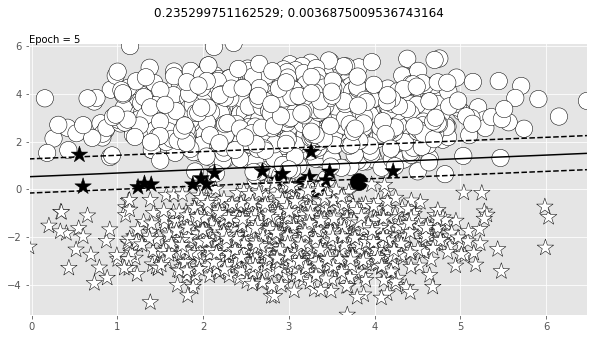

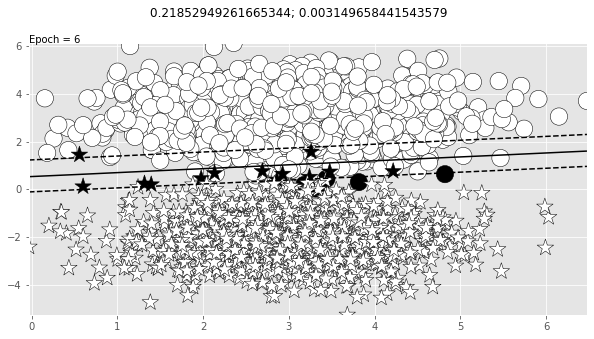

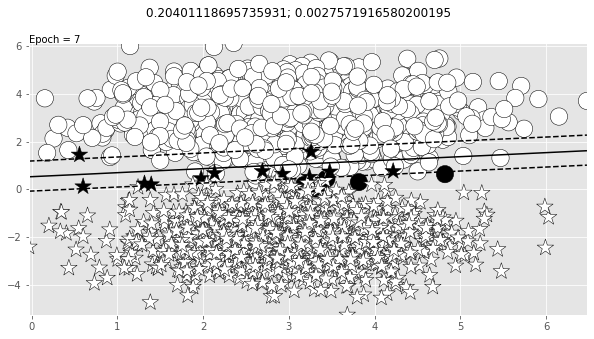

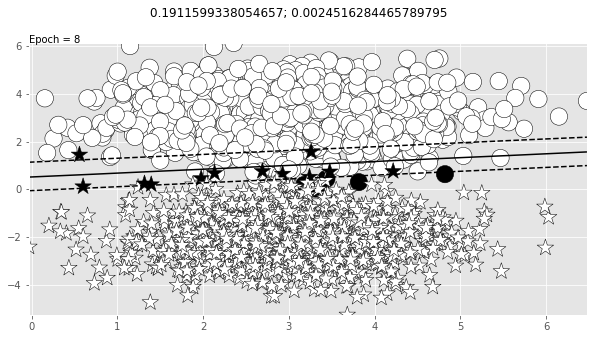

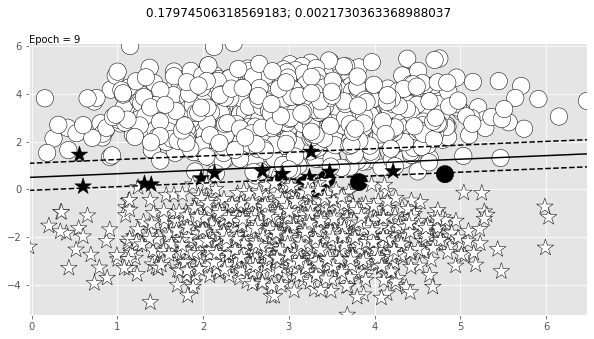

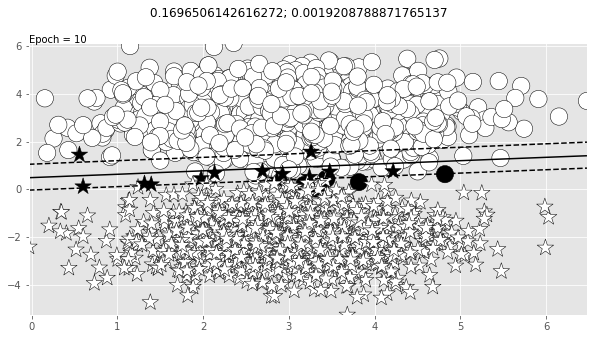

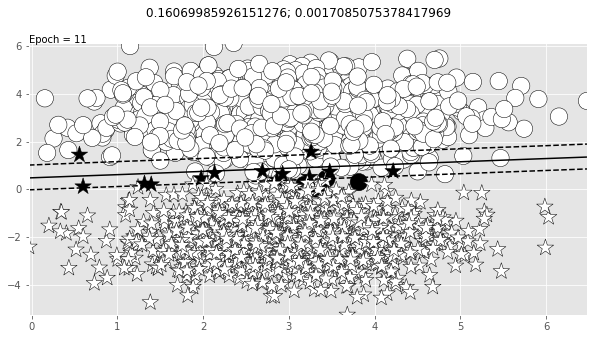

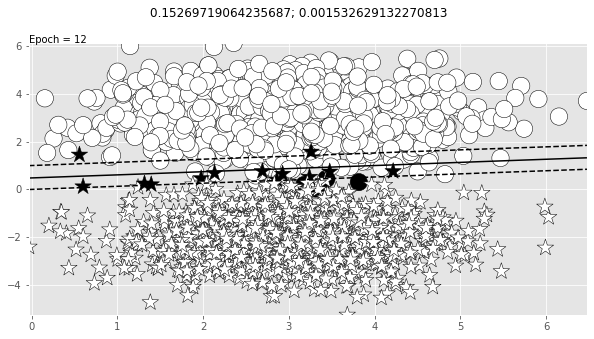

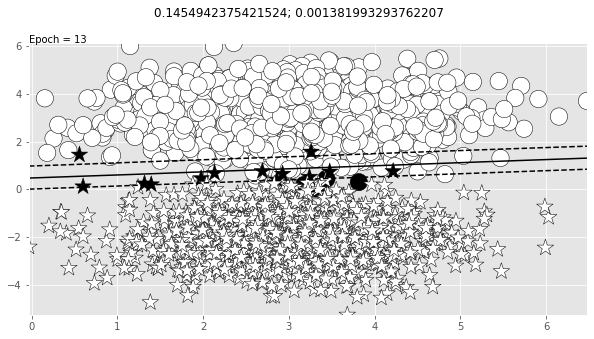

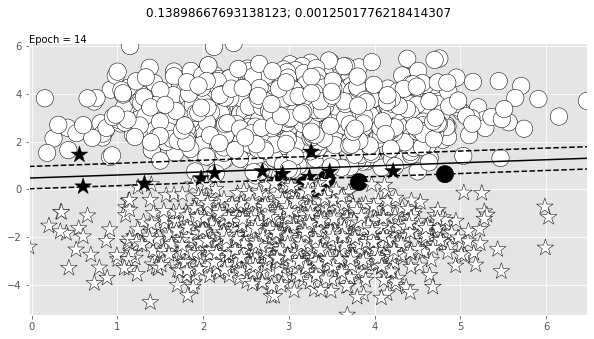

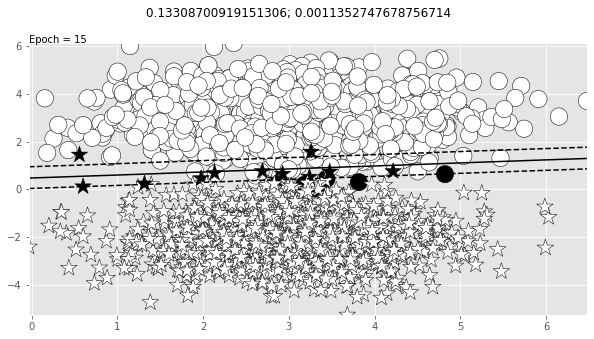

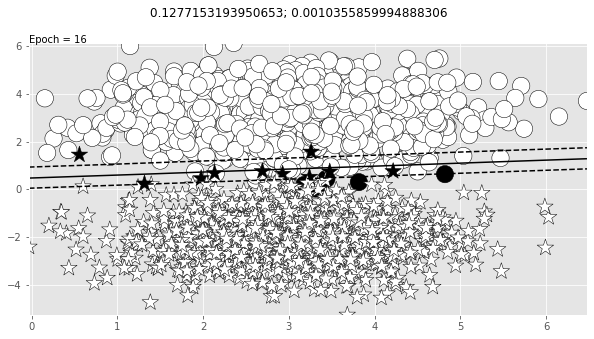

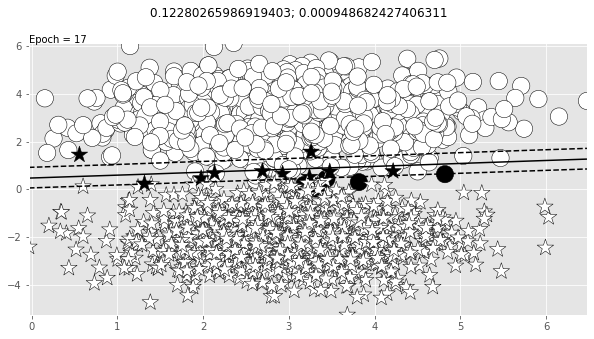

In [21]:
losses = fit(perceptron, optimizer, bce_loss, X_train, y_train, X_data, y_truth)

No handles with labels found to put in legend.


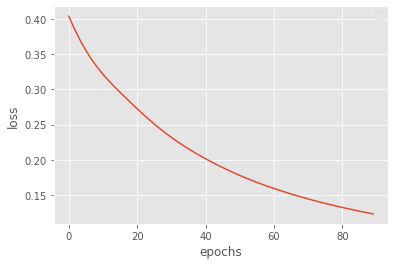

In [22]:
plt.plot(losses, )
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Predicción

In [23]:
m = y_test.size()[0]

In [36]:
perceptron.eval()
predictions = perceptron(X_test).view(-1)

In [30]:
y_test

tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 1.])

In [37]:
y_hat = predictions >0.5

In [38]:
torch.sum(y_test == y_hat).float()

tensor(196.)

In [40]:
(torch.sum(y_test == y_hat).float()) /m

tensor(0.9800)

## Ejercicios

1. Ocupar una instacia de Perceptron para clastificar la salida de *get_toy_data*.
2. Cambiar las etiquetas $y \in \{0, 1\}$ por $y \in \{-1, 1\}$. En este caso ocupar la función de activación tanh para la capa de salida del perceptrón modificado y entrenar bajo este esquema.
3. Relizar una regresión lineal usando el modelo ADALINE.